# Setup

In [1]:
%load_ext autoreload
%autoreload 2
import os

%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from scipy.stats import norm, skew

import math
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

#from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
import category_encoders as ce
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_log_error
from scipy.special import boxcox1p
from scipy.stats import boxcox


import string
import warnings
warnings.filterwarnings('ignore')

In [3]:
!ls ../input

crisis-20082009-housing-data  house-prices-advanced-regression-techniques


In [4]:
PATH = "../input/house-prices-advanced-regression-techniques/"

In [5]:
df_train=pd.read_csv(f'{PATH}train.csv')#, index_col='Id')
df_test=pd.read_csv(f'{PATH}test.csv')#, index_col='Id')

In [6]:
# for the purpose of evaluation of current competition we transform target value
df_train.SalePrice = np.log1p(df_train.SalePrice)

In [7]:
print('Number of Training Examples = {}'.format(df_train.shape[0]))
print('Number of Test Examples = {}\n'.format(df_test.shape[0]))
print('Training X Shape = {}'.format(df_train.shape))
print('Training y Shape = {}\n'.format(df_train['SalePrice'].shape[0]))
print('Test X Shape = {}'.format(df_test.shape))
print('Test y Shape = {}\n'.format(df_test.shape[0]))
#print(df_train.columns)
#print(df_test.columns)

Number of Training Examples = 1460
Number of Test Examples = 1459

Training X Shape = (1460, 81)
Training y Shape = 1460

Test X Shape = (1459, 80)
Test y Shape = 1459



# Remove Outliers

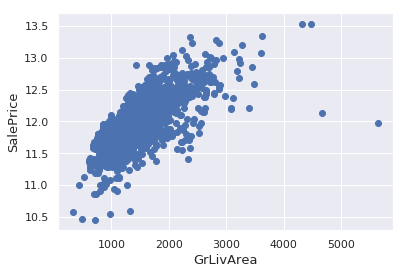

In [8]:
fig, ax = plt.subplots()
ax.scatter(x = df_train['GrLivArea'], y = df_train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

(1458, 81)


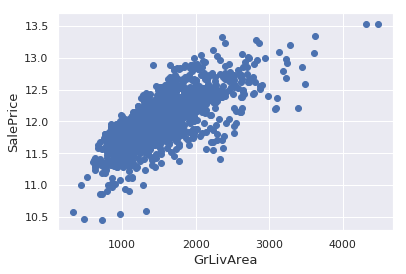

In [9]:
# Deleting outliers
df_train = df_train.drop(df_train[(df_train['GrLivArea']>4000) & (df_train['SalePrice']<12.5)].index)
print(df_train.shape)
#Check the graphic again
fig, ax = plt.subplots()
ax.scatter(df_train['GrLivArea'], df_train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

# DataFrame concatenation

In [10]:
#remember where to divide train and test
ntrain = df_train.shape[0] #1458
ntest = df_test.shape[0] # 1459

#Save the 'Id' column
train_ID = df_train['Id']
test_ID = df_test['Id']

In [11]:
def concat_df(train_data, test_data):
    # Returns a concatenated df of training and test set on axis 0
    return pd.concat([train_data, test_data], sort=True).reset_index(drop=True)

df_all = concat_df(df_train, df_test)
print(df_all.shape)
df_train.name = 'Training Set'
df_test.name = 'Test Set'
df_all.name = 'All Set' 

dfs = [df_train, df_test] # list with two DataFrames

df_all.shape

(2917, 81)


(2917, 81)

In [12]:
#Dividing Target column (Y)
y_train_full = df_train.SalePrice.values
df_all.drop(['SalePrice'], axis=1, inplace=True)
df_all.drop('Id',axis=1,inplace=True)
print(df_all.shape)


(2917, 79)


In [13]:
y_train_full

array([12.24769912, 12.10901644, 12.31717117, ..., 12.49313327,
       11.86446927, 11.90159023])

# Missing Values Processing

### Create columns to mark originally missed values

In [14]:
def mark_missing (df):
    """
    If df has column with missing value, create new columns indicate whether it is missing or not
    """
    for col in df.columns:
        if df[col].isnull().sum()>0:
            df[col+'_missed']=df[col].isnull()

In [15]:
mark_missing(df_all)

### Replace Missing Values

In [16]:
def display_missing(df):
    for col in df.columns:
        print(col, df[col].isnull().sum())
    print('\n')
    
for df in dfs:   # defined earlier, #dfs = [df_train, df_test] # list with two DataFrames
    print(format(df.name))
    display_missing(df)

Training Set
Id 0
MSSubClass 0
MSZoning 0
LotFrontage 259
LotArea 0
Street 0
Alley 1367
LotShape 0
LandContour 0
Utilities 0
LotConfig 0
LandSlope 0
Neighborhood 0
Condition1 0
Condition2 0
BldgType 0
HouseStyle 0
OverallQual 0
OverallCond 0
YearBuilt 0
YearRemodAdd 0
RoofStyle 0
RoofMatl 0
Exterior1st 0
Exterior2nd 0
MasVnrType 8
MasVnrArea 8
ExterQual 0
ExterCond 0
Foundation 0
BsmtQual 37
BsmtCond 37
BsmtExposure 38
BsmtFinType1 37
BsmtFinSF1 0
BsmtFinType2 38
BsmtFinSF2 0
BsmtUnfSF 0
TotalBsmtSF 0
Heating 0
HeatingQC 0
CentralAir 0
Electrical 1
1stFlrSF 0
2ndFlrSF 0
LowQualFinSF 0
GrLivArea 0
BsmtFullBath 0
BsmtHalfBath 0
FullBath 0
HalfBath 0
BedroomAbvGr 0
KitchenAbvGr 0
KitchenQual 0
TotRmsAbvGrd 0
Functional 0
Fireplaces 0
FireplaceQu 690
GarageType 81
GarageYrBlt 81
GarageFinish 81
GarageCars 0
GarageArea 0
GarageQual 81
GarageCond 81
PavedDrive 0
WoodDeckSF 0
OpenPorchSF 0
EnclosedPorch 0
3SsnPorch 0
ScreenPorch 0
PoolArea 0
PoolQC 1452
Fence 1177
MiscFeature 1404
MiscVal 0
M

In [17]:
#Check remaining missing values if any 
def display_only_missing(df):
    all_data_na = (df.isnull().sum() / len(df)) * 100
    all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
    missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
    print(missing_data)
    
display_only_missing(df_all)


              Missing Ratio
PoolQC            99.691464
MiscFeature       96.400411
Alley             93.212204
Fence             80.425094
FireplaceQu       48.680151
LotFrontage       16.660953
GarageQual         5.450806
GarageCond         5.450806
GarageFinish       5.450806
GarageYrBlt        5.450806
GarageType         5.382242
BsmtExposure       2.811107
BsmtCond           2.811107
BsmtQual           2.776826
BsmtFinType2       2.742544
BsmtFinType1       2.708262
MasVnrType         0.822763
MasVnrArea         0.788481
MSZoning           0.137127
BsmtFullBath       0.068564
BsmtHalfBath       0.068564
Utilities          0.068564
Functional         0.068564
Electrical         0.034282
BsmtUnfSF          0.034282
Exterior1st        0.034282
Exterior2nd        0.034282
TotalBsmtSF        0.034282
GarageArea         0.034282
GarageCars         0.034282
BsmtFinSF2         0.034282
BsmtFinSF1         0.034282
KitchenQual        0.034282
SaleType           0.034282


### Replace non-missing but "NA", "None", etc values by Data description

##### Replace NA in Object columns, based on information from description. 
##### For these attributes, Null means None

In [18]:
# fill NA values (not missed) with None - based on data description -  - for non-Numerical (object) Columns
for col in ('Alley','MasVnrType','BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 
            'BsmtFinType2','FireplaceQu','GarageType', 'GarageFinish', 'GarageQual', 
            'GarageCond','PoolQC','Fence','MiscFeature'):
    df_all[col] = df_all[col].fillna('None')

##### Replace NA in Numerical columns, based on information from description
##### For these attributes, Null means 0

In [19]:
display_only_missing(df_all)

              Missing Ratio
LotFrontage       16.660953
GarageYrBlt        5.450806
MasVnrArea         0.788481
MSZoning           0.137127
Utilities          0.068564
BsmtFullBath       0.068564
BsmtHalfBath       0.068564
Functional         0.068564
Exterior1st        0.034282
BsmtFinSF2         0.034282
BsmtUnfSF          0.034282
Electrical         0.034282
GarageArea         0.034282
Exterior2nd        0.034282
TotalBsmtSF        0.034282
GarageCars         0.034282
KitchenQual        0.034282
SaleType           0.034282
BsmtFinSF1         0.034282


In [20]:
#fill NA numerical value with '0' - based on data description of correspondent Object columns - for Numerical Columns
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars','BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath','MasVnrArea'):
    df_all[col] = df_all[col].fillna(0)

### Replacing real missing values

We also have REAL missing values, that we can't just replace based on description that if missed - use 'None' or 0. Hence, we will work here

#### Iteration 1 - replacing by logic and deduction of human

##### Replace NA missing values by most often in column (only for columns with 2 and less NA values, where do not make sense to invest hugely into Analysis)

In [21]:
display_only_missing(df_all)

             Missing Ratio
LotFrontage      16.660953
MSZoning          0.137127
Utilities         0.068564
Functional        0.068564
SaleType          0.034282
KitchenQual       0.034282
Exterior2nd       0.034282
Exterior1st       0.034282
Electrical        0.034282


In [22]:
# Fill missing value in corresponding columns with most frequent value in column
for col in ('Utilities','Functional','SaleType','KitchenQual','Exterior2nd','Exterior1st','Electrical'):
    df_all[col].fillna(df_all[col].mode()[0], inplace=True)
    
# Functional : data description says NA means typical
# BTW we just used df_all.Functional.mode() = use most frequent value (as 'Typ' is most frequent value)
#df_all["Functional"] = df_all["Functional"].fillna("Typ")

##### Dealing with missing values left

In [23]:
display_only_missing(df_all)

             Missing Ratio
LotFrontage      16.660953
MSZoning          0.137127


##### Dealing with MSZoning

In [24]:
df_all.MSZoning.isnull().sum()
print(df_all["MSZoning"][:4])

0    RL
1    RL
2    RL
3    RL
Name: MSZoning, dtype: object


In MSZoning we have 4 missing values. 
We can replace them either by most common in column, or I have decided just with 'None' object values

In [25]:
df_all["MSZoning"] = df_all["MSZoning"].fillna("None")

In [26]:
display_only_missing(df_all)

             Missing Ratio
LotFrontage      16.660953


In [27]:
#### Iteration 2 - replacing by machine learning

##### Dealing with LotFrontage

In [28]:
df_all['LotFrontage'].isnull().sum()

486

In [29]:
#Group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood
df_all["LotFrontage"] = df_all.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

In [30]:
df_all['LotFrontage'].isnull().sum()

0

In [31]:
display_only_missing(df_all)

Empty DataFrame
Columns: [Missing Ratio]
Index: []


In [32]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2917 entries, 0 to 2916
Columns: 113 entries, 1stFlrSF to Utilities_missed
dtypes: bool(34), float64(11), int64(25), object(43)
memory usage: 1.9+ MB


##### Seems no missed values
Missing Values = DONE

# Pre-Evaluation - benchmarking

## Making Training, Validation, Test Dataset

In [33]:
# Function Splitting Train - Validation
def quick_get_dumm(df):
    X_train_full=df.iloc[:ntrain] # Full Train set

    # Creating train and validation sets
    X_train, X_valid, y_train, y_valid = train_test_split(pd.get_dummies(X_train_full), y_train_full, random_state=42)
    return X_train, X_valid, y_train, y_valid

In [34]:
X_train, X_valid, y_train, y_valid = quick_get_dumm(df_all)

In [35]:
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((1093, 335), (365, 335), (1093,), (365,))

## Evaluation

In [36]:
# Defining evaluation functions
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m,X_train=X_train, X_valid=X_valid, y_train=y_train, y_valid=y_valid):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

### Random Forest

In [37]:
m_rf = RandomForestRegressor(n_estimators=160, min_samples_leaf=1, max_features=0.5, n_jobs=-1, oob_score=True, random_state=42)
m_rf.fit(X_train, y_train)
print_score(m_rf)

[0.04997004846641644, 0.13326140106089882, 0.9842627154330733, 0.890785827175014, 0.8832511731774426]


### ElasticNet

In [38]:
def elastic_score(X,y):
    elastic = ElasticNet(random_state=1)
    param = {'l1_ratio' : [0],
             'alpha' : [0.017]}
    elastic = GridSearchCV(elastic, param, cv=5, scoring='neg_mean_squared_error')
    elastic.fit(X,y)
    print('Elastic:', np.sqrt(elastic.best_score_*-1))
    return elastic

In [39]:
elastic_score(X_train, y_train)

Elastic: 0.11464778008180791


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True,
                                  l1_ratio=0.5, max_iter=1000, normalize=False,
                                  positive=False, precompute=False,
                                  random_state=1, selection='cyclic',
                                  tol=0.0001, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'alpha': [0.017], 'l1_ratio': [0]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

### XGBoost

In [40]:
m_xgb = XGBRegressor(n_estimators=160, learning_rate=0.05, random_state=42)
# using early_stop to find out where validation scores don't improve
#m_xgb.fit(X_train, y_train, early_stopping_rounds=5, eval_set=[(X_valid, y_valid)], verbose=False)
m_xgb.fit(X_train, y_train)
print_score(m_xgb)

[05:18:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0.08916323716382606, 0.12395222904221555, 0.9498949024701104, 0.905511504678163]


# Dealing with missing values based on machine learning predictions

We will try ML techniques to predict all real missing values. We'll see how it will improve accuracy

##### Once again dealing with missed LotFrontage feature

In [41]:
# We created function to return NA values of feature/column back in place, 
# based on _missed column, we created to state what values was missed in original dataset

# returning original NA values back
def return_original_na(df, feature):
    df[feature].loc[df.index[df[feature+'_missed'] == True].tolist()]=np.nan
    return df[feature]

In [42]:
#Returning original NA values of MSZoning back in place
df_all['LotFrontage']=return_original_na(df_all, 'LotFrontage')

In [43]:
df_all['LotFrontage'].isnull().sum()

486

In [44]:
display_only_missing(df_all)

             Missing Ratio
LotFrontage      16.660953


In [45]:
def filling_na_with_predictions(df, feature):
    """
    df - DataFrame without target column y. Train+Test DataFrame (df_all)
    feature - feature (column), containing real NA values we will fill

    Assumption:
    All other columns do not have NA values. In case of having we have to impute with some Statistical method (Median, etc)
    We do not do it inside this function
    """

    flag_object=0
    
    if df[feature].isnull().sum()>0:
        ## Store Indexes of rows with NA values (we can just call "_missed" column with True values, to check those indexes as well)
        ## Creating index based on NA values present in column
        na_rows_idxs=df[df[feature].isnull()].index 
            ## Creating index based on NA values being present in original DF column
            #na_rows_idxs=df.index[df[feature+'_missed'] == True].tolist()

        ## For fitting and predictiong - convert DF to dummies DF, ready for ML
        #df=pd.get_dummies(df)
        ## If feature object we cant just dummy all, we shouldn't dummy feature column
        df=pd.concat([ pd.Series(df[feature]), pd.get_dummies(df.drop([feature], axis=1)) ], axis=1)


        ## Splitting DF to Feature_Train_X, Feature_Train_y, Feature_Predict_X:
        ## Feature_Train_X = DF without NA values in "feature_with_NA"column
        ## Feature_Train_y = target values that we have. All values in "feature_with_NA" except NA values
        ## Feature_Predict_X = DF of correcponding to NA values in "feature_with_NA" without target vales (basically because they is equal to NA)
        Feature_Train_X=df.drop(df[df[feature].isnull()].index).drop([feature], axis=1)
        Feature_Train_y=df[feature].drop(df[df[feature].isnull()].index).values
        Feature_Predict_X=df[df[feature].isnull()].drop([feature], axis=1)

        ## If feature is NOT Numerical
        ## Label encoding of y values in case it is not numerical
        if is_string_dtype(df[feature]) or is_categorical_dtype(df[feature]):
            flag_object=1
            from sklearn.preprocessing import LabelEncoder
            le = LabelEncoder()
            le.fit(Feature_Train_y)
            Feature_Train_y=le.transform(Feature_Train_y)
             
        ## Making predictions, what might be in NA fields based on Train DF
        #m_xgb = XGBRegressor(n_estimators=160, learning_rate=0.05)
        #m_xgb.fit(Feature_Train_X, Feature_Train_y)
        elastic = ElasticNet(random_state=1)
        param = {'l1_ratio' : [0],
             'alpha' : [0.017]}
        elastic = GridSearchCV(elastic, param, cv=5, scoring='neg_mean_squared_error')
        elastic.fit(Feature_Train_X,Feature_Train_y)
    
        ## Creating (Predicting) values to impute NA
        #fillna_values=m_xgb.predict(Feature_Predict_X)
        fillna_values=elastic.predict(Feature_Predict_X)

        ## If feature is NOT Numerical
        ## Return Encoded values back to Object/Category if feature NOT numerical
        if flag_object==1:
            fillna_values=le.inverse_transform(np.around(fillna_values).astype(int))
        
        ## Replacing NA values with predicted Series of values
        df[feature]=df[feature].fillna(pd.Series(index=na_rows_idxs,data=fillna_values))

        ## Returning feature column without NA values    
        return df[feature]
    else:
        print ('There were no NA values')

In [46]:
# Datafremas to predict missed LotFrontage in train test. We add SalePrice to exploit all data that we have, hence to have more accuracy.
# As next step we will use concatenated dataframe Train+Test but without SalePrice, as we don't have SalePrice column for test, hence can't use this info to restore missed values of LotFrontage in Test dataset
df_tmp_train=df_all.iloc[:ntrain] # Full Train set
df_tmp_train['SalePrice']=y_train_full
df_tmp_test=df_all.iloc[ntrain:] # Test set

In [47]:
# Replacing missing LotFrontage values in Train dataset
df_tmp_train['LotFrontage']=filling_na_with_predictions(df_tmp_train, "LotFrontage")
# Replacing missing LotFrontage values in Test dataset
df_tmp_test['LotFrontage']=filling_na_with_predictions(df_tmp_test, "LotFrontage")

In [48]:
df_tmp_train.drop(['SalePrice'], axis=1, inplace=True)
df_all = concat_df(df_tmp_train, df_tmp_test)

In [49]:
df_all['LotFrontage'].isnull().sum()

0

In [50]:
def evaluate(df):
    # Split dataset for train-validation
    X_train, X_valid, y_train, y_valid = quick_get_dumm(df)
    
    #ElasticNet
    elastic_score(X_train, y_train)

    #XGBoost
    m_xgb.fit(X_train, y_train)
    print('XGBoost')
    print_score(m_xgb,X_train, X_valid, y_train, y_valid)

    # Random Forest
    m_rf.fit(X_train, y_train)
    print('Random Forest')
    print_score(m_rf,X_train, X_valid, y_train, y_valid)

In [51]:
evaluate(df_all)

Elastic: 0.11456035804985812
[05:18:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBoost
[0.08930467911021037, 0.1239663137938931, 0.9497358103630971, 0.9054900299113812]
Random Forest
[0.049832895227114045, 0.13345800033043048, 0.9843489854090125, 0.8904633442246035, 0.8836091747444947]


Great! As we can see in all 3 models scores improved using ML algorithms to replace missing values

##### Once again dealing with missed MSZoning feature

In [52]:
#Returning original NA values of MSZoning back in place
df_all['MSZoning']=return_original_na(df_all, 'MSZoning')

In [53]:
display_only_missing(df_all)

          Missing Ratio
MSZoning       0.137127


In [54]:
df_all[df_all['MSZoning'].isnull()].index

Int64Index([1913, 2214, 2248, 2902], dtype='int64')

In [55]:
df_all['MSZoning']=filling_na_with_predictions(df_all, 'MSZoning')

In [56]:
df_all['MSZoning'].loc[df_all.index[df_all['MSZoning'+'_missed'] == True].tolist()]

1913    RH
2214    RL
2248    RL
2902    RL
Name: MSZoning, dtype: object

As we can see we had all 'RL' values for MSZoning column, but ML algorithms proposed to change it a little bit. Let's check score

In [57]:
evaluate(df_all)

Elastic: 0.11456035804985812
[05:19:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBoost
[0.08930467911021037, 0.1239663137938931, 0.9497358103630971, 0.9054900299113812]
Random Forest
[0.04983289522711405, 0.13345800033043048, 0.9843489854090125, 0.8904633442246034, 0.8836091747444947]


In [58]:
##### Dealing with Missing values we replaced with most common - now replacing them with ML predictions

In [59]:
for col in ('Utilities','Functional','SaleType','KitchenQual','Exterior2nd','Exterior1st','Electrical'):
    print ('Filling with most common:\n',df_all[col].loc[df_all.index[df_all[col+'_missed'] == True].tolist()])
    df_all[col]=return_original_na(df_all, col)
    df_all[col]=filling_na_with_predictions(df_all, col)
    print ('Filling with predictions:\n',df_all[col].loc[df_all.index[df_all[col+'_missed'] == True].tolist()])

Filling with most common:
 1913    AllPub
1943    AllPub
Name: Utilities, dtype: object
Filling with predictions:
 1913    AllPub
1943    AllPub
Name: Utilities, dtype: object
Filling with most common:
 2214    Typ
2471    Typ
Name: Functional, dtype: object
Filling with predictions:
 2214    Sev
2471    Sev
Name: Functional, dtype: object
Filling with most common:
 2487    WD
Name: SaleType, dtype: object
Filling with predictions:
 2487    WD
Name: SaleType, dtype: object
Filling with most common:
 1553    TA
Name: KitchenQual, dtype: object
Filling with predictions:
 1553    TA
Name: KitchenQual, dtype: object
Filling with most common:
 2149    VinylSd
Name: Exterior2nd, dtype: object
Filling with predictions:
 2149    Wd Sdng
Name: Exterior2nd, dtype: object
Filling with most common:
 2149    VinylSd
Name: Exterior1st, dtype: object
Filling with predictions:
 2149    VinylSd
Name: Exterior1st, dtype: object
Filling with most common:
 1377    SBrkr
Name: Electrical, dtype: object
Fil

In [60]:
evaluate(df_all)

Elastic: 0.11456035804985812
[05:20:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBoost
[0.08930467911021037, 0.1239663137938931, 0.9497358103630971, 0.9054900299113812]
Random Forest
[0.04983289522711405, 0.13345800033043057, 0.9843489854090125, 0.8904633442246035, 0.8836091747444947]


As we can see - nothing in scores changed, so it was unnecessary step, possibly because these last features weren't important for models

## Saving DataFrame for next Steps

In [61]:
# Saving Train Dataset after cleaning
df_train_save=df_all.iloc[:ntrain]
df_train_save['SalePrice']=y_train_full

# Saving Test Dataset after cleaning
df_test_save=df_all.iloc[ntrain:] # Test set
#df_test_save['Id']=test_ID

In [62]:
df_test_save.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,Alley_missed,BedroomAbvGr,BldgType,BsmtCond,BsmtCond_missed,BsmtExposure,...,Street,TotRmsAbvGrd,TotalBsmtSF,TotalBsmtSF_missed,Utilities,Utilities_missed,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
1458,896,0,0,None,True,2,1Fam,TA,False,No,...,Pave,5,882.0,False,AllPub,False,140,1961,1961,2010
1459,1329,0,0,None,True,3,1Fam,TA,False,No,...,Pave,6,1329.0,False,AllPub,False,393,1958,1958,2010
1460,928,701,0,None,True,3,1Fam,TA,False,No,...,Pave,6,928.0,False,AllPub,False,212,1997,1998,2010
1461,926,678,0,None,True,3,1Fam,TA,False,No,...,Pave,7,926.0,False,AllPub,False,360,1998,1998,2010
1462,1280,0,0,None,True,2,TwnhsE,TA,False,No,...,Pave,5,1280.0,False,AllPub,False,0,1992,1992,2010


In [63]:
df_train_save.to_csv('train_clean.csv', index=False)
df_test_save.to_csv('test_clean.csv', index=False)

# Preparing clean data for ML

## Dealining with Scewed data

In [64]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
skewness = df_all.select_dtypes(include=numerics).apply(lambda x: skew(x))
skew_index = skewness[abs(skewness) >= 0.85].index
skewness[skew_index].sort_values(ascending=False)

MiscVal          21.939672
PoolArea         17.688664
LotArea          13.109495
LowQualFinSF     12.084539
3SsnPorch        11.372080
KitchenAbvGr      4.300550
BsmtFinSF2        4.144503
EnclosedPorch     4.002344
ScreenPorch       3.945101
BsmtHalfBath      3.929996
MasVnrArea        2.621719
OpenPorchSF       2.529358
WoodDeckSF        1.844792
MSSubClass        1.375131
1stFlrSF          1.257286
GrLivArea         1.068750
LotFrontage       1.015121
BsmtFinSF1        0.980645
BsmtUnfSF         0.919688
2ndFlrSF          0.861556
GarageYrBlt      -3.904632
dtype: float64

In [65]:
'''BoxCox Transform'''
lam = 0.15

for column in skew_index:
    df_all[column] = boxcox1p(df_all[column], lam)


In [66]:
# Evaluation after working with skewed data
evaluate(df_all)

Elastic: 0.11262553534057317
[05:20:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBoost
[0.08930467911021037, 0.12397501849622991, 0.9497358103630971, 0.9054767567887735]
Random Forest
[0.04979803327279702, 0.1336686534291523, 0.9843708759333268, 0.8901172810983596, 0.883765794734912]


After this step we drastically improved scores, especially ElasticNet

## Dummies

In [67]:
df_all.shape
df_all=pd.get_dummies(df_all)

In [68]:
df_all.shape

(2917, 335)

In [69]:
"""Dividing working DataFrame back to Train and Test"""
# split Validational/Test set from Training set after Categorical Value Engeneering
#def original_train_test(df_all):
X_test=df_all.iloc[ntrain:] # Test set
X_train_full=df_all.iloc[:ntrain] # Train set
X_train, X_valid, y_train, y_valid = train_test_split(pd.get_dummies(X_train_full), y_train_full)

## Dropping low variance features

In [70]:
(df_all==0).sum()>=2900
print(df_all.shape)
print((df_all==0).sum().shape)


(2917, 335)
(335,)


In [71]:
# Saving all features for future comparison.
print(df_all.shape)
all_features = df_all.keys()
# Removing features.
df_all = df_all.drop(df_all.loc[:,(df_all==0).sum()>=(df_all.shape[0]*0.984)],axis=1)
df_all = df_all.drop(df_all.loc[:,(df_all==1).sum()>=(df_all.shape[0]*0.984)],axis=1) 
print(df_all.shape)
# Getting and printing the remaining features.
remain_features = df_all.keys()
remov_features = [st for st in all_features if st not in remain_features]
print(len(remov_features), 'features were removed:', remov_features)

(2917, 335)
(2917, 206)
129 features were removed: ['3SsnPorch', 'BsmtFinSF1_missed', 'BsmtFinSF2_missed', 'BsmtFullBath_missed', 'BsmtHalfBath_missed', 'BsmtUnfSF_missed', 'Electrical_missed', 'Exterior1st_missed', 'Exterior2nd_missed', 'Functional_missed', 'GarageArea_missed', 'GarageCars_missed', 'KitchenQual_missed', 'LowQualFinSF', 'MSZoning_missed', 'MasVnrArea_missed', 'MasVnrType_missed', 'PoolArea', 'PoolQC_missed', 'SaleType_missed', 'TotalBsmtSF_missed', 'Utilities_missed', 'BsmtCond_Po', 'BsmtFinType2_GLQ', 'Condition1_PosA', 'Condition1_PosN', 'Condition1_RRAe', 'Condition1_RRNe', 'Condition1_RRNn', 'Condition2_Artery', 'Condition2_Feedr', 'Condition2_Norm', 'Condition2_PosA', 'Condition2_PosN', 'Condition2_RRAe', 'Condition2_RRAn', 'Condition2_RRNn', 'Electrical_FuseP', 'Electrical_Mix', 'ExterCond_Ex', 'ExterCond_Po', 'ExterQual_Fa', 'Exterior1st_AsbShng', 'Exterior1st_AsphShn', 'Exterior1st_BrkComm', 'Exterior1st_CBlock', 'Exterior1st_ImStucc', 'Exterior1st_Stone', 'Ext

In [72]:
# Evaluation after dropping not important features
evaluate(df_all)

Elastic: 0.1127893610762106
[05:20:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBoost
[0.09026865171652936, 0.12453091600700959, 0.9486448303674151, 0.9046271817486177]
Random Forest
[0.05026246056424722, 0.13461444627774719, 0.9840779953160957, 0.8885567961205375, 0.8817736334332313]


## Normalization

In [73]:
from sklearn import preprocessing

scaler = preprocessing.RobustScaler()
df_all = pd.DataFrame(scaler.fit_transform(df_all))

In [74]:
# Evaluation after Normalization
evaluate(df_all)

Elastic: 0.11250295997976706
[05:20:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBoost
[0.09026865171652936, 0.12449577779504571, 0.9486448303674151, 0.9046809958152209]
Random Forest
[0.050251434177054036, 0.13468153517569945, 0.9840849803673442, 0.8884456867258659, 0.8818234523402193]


Great! We are ready to Train real model

## Pred ML Evaluation

In [75]:
"""Dividing working DataFrame back to Train and Test"""
# split Validational/Test set from Training set after Categorical Value Engeneering
#def original_train_test(df_all):
X_test=df_all.iloc[ntrain:] # Test set
X_train_full=df_all.iloc[:ntrain] # Train set
X_train, X_valid, y_train, y_valid = train_test_split(pd.get_dummies(X_train_full), y_train_full)

In [76]:
# ElasticNet
print('ElasticNet')
def elastic_score(X,y):
    elastic = ElasticNet(random_state=1)
    param = {'l1_ratio' : [0],
             'alpha' : [0.017]}
    elastic = GridSearchCV(elastic, param, cv=5, scoring='neg_mean_squared_error')
    elastic.fit(X,y)
    print('ElasticNet:', np.sqrt(elastic.best_score_*-1))
    return elastic
elastic_score(X_train, y_train)

# XGBoost
print('XGBoost')
m_xgb = XGBRegressor(n_estimators=160, learning_rate=0.05)
# using early_stop to find out where validation scores don't improve
#m_xgb.fit(X_train, y_train, early_stopping_rounds=5, eval_set=[(X_valid, y_valid)], verbose=False)
m_xgb.fit(X_train, y_train)
print_score(m_xgb,X_train, X_valid, y_train, y_valid)


# Random Forest
print('Random Forest')
m_rf = RandomForestRegressor(n_estimators=160, min_samples_leaf=1, max_features=0.5, n_jobs=-1, oob_score=True)
m_rf.fit(X_train, y_train)
print_score(m_rf,X_train, X_valid, y_train, y_valid)


ElasticNet
ElasticNet: 0.10642852606502848
XGBoost
[05:20:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0.08576940045745131, 0.14311854903402912, 0.9529419314517958, 0.8784376773330775]
Random Forest
[0.049015419908572486, 0.14918085248744334, 0.984631382406321, 0.8679211407257907, 0.8861622769540228]


# Machine Learning

In [77]:
def cv_train():
    elastic = ElasticNet(random_state=1)
    param = {'l1_ratio' : [0],
             'alpha' : [0.017]}
    elastic = GridSearchCV(elastic, param, cv=5, scoring='neg_mean_squared_error')
    elastic.fit(X_train_full, y_train_full)
    print('Elastic:', np.sqrt(elastic.best_score_*-1))
    return elastic
elastic = cv_train()

Elastic: 0.11335215685678109


## Predictions for submission

In [78]:
y_pred=np.expm1(elastic.predict(X_test)); y_pred

array([115917.58343119, 152774.85206079, 183214.10844056, ...,
       175673.10779833, 117195.70395737, 221682.04593581])

# Submission

In [79]:
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = y_pred
sub.to_csv('submission.csv',index=False)